In [43]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Device

In [44]:
# Get gpu device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.benchmark = True
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA GeForce GTX 1080 Ti', major=6, minor=1, total_memory=11263MB, multi_processor_count=28)

## Download CIFAR100 dataset

In [45]:
# Normalize a tensor image with mean and standard deviation of 0.5
transform = Compose([ToTensor(), Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]).to(device)])

# Download train data
training_data = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

# Download test data
test_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

Files already downloaded and verified
Files already downloaded and verified


### Number of classes

In [46]:
n_classes = len(test_data.classes)
n_classes

100

## Dataloaders

In [47]:
batch_size = 512
image_size = 32 * 32 * 3

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([512, 3, 32, 32])
Shape of y: torch.Size([512]) torch.int64


In [48]:
print(len(train_dataloader.dataset))
print(len(test_dataloader.dataset))

50000
10000


## Define model

In [49]:

print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self, hidden_layers=[512, 256, 128], activations=[nn.ReLU(), nn.ReLU(), nn.ReLU()], batch_norm=[False, False, False], dropout=[0, 0, 0], n_classes=2):
        super().__init__()
    
        self.flatten = nn.Flatten()

        layers = []

        layers.append(nn.Linear(image_size, hidden_layers[0]))
        layers.append(nn.BatchNorm1d(hidden_layers[0]))
        layers.append(activations[0])
        layers.append(nn.Dropout(dropout[0]))
        
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.BatchNorm1d(hidden_layers[i+1]))
            layers.append(activations[i+1])
            layers.append(nn.Dropout(dropout[i+1]))
            
        layers.append(nn.Linear(hidden_layers[-1], n_classes))
        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        return logits

model = NeuralNetwork(hidden_layers = [1024, 512, 256, 128], activations=[nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], batch_norm=[True]*4, dropout=[0.5]*4, n_classes=n_classes).to(device)
print(model)

Using cuda:0 device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=128, out_features=100, bias=

## Define optimizer and loss function

In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Learning rate schedule (One cycle policy)

In [51]:
import torch.optim.lr_scheduler as lr_scheduler

epochs = 20

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.01, epochs=20, steps_per_epoch=len(train_dataloader))
# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=1e-3, total_iters=epochs) # linear
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97) # exponential

## Training loop

In [52]:
train_loss_history = []
lr_history = []

In [53]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        scheduler.step()
        lr_history.append(scheduler.get_last_lr())

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
            
    train_loss /= len(dataloader)
    train_loss_history.append(train_loss)

In [54]:
test_loss_history = []
test_metric_history = []

In [55]:
def test(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    test_loss_history.append(test_loss)
    test_metric_history.append(correct * 100)
    

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n lr: {optimizer.param_groups[0]['lr']}")
    print("_______________________________")

In [56]:
for i in range(epochs):
    print(f"Epoch {i+1}\n")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1



loss: 4.779603  [  512/50000]
Test Error: 
 Accuracy: 6.7%, Avg loss: 4.208201 
 lr: 0.0010452204939138503
_______________________________
Epoch 2

loss: 4.324042  [  512/50000]
Test Error: 
 Accuracy: 11.0%, Avg loss: 3.809421 
 lr: 0.002807419689919391
_______________________________
Epoch 3

loss: 3.972541  [  512/50000]
Test Error: 
 Accuracy: 12.7%, Avg loss: 3.678303 
 lr: 0.00521284465650775
_______________________________
Epoch 4

loss: 3.892446  [  512/50000]
Test Error: 
 Accuracy: 14.6%, Avg loss: 3.584964 
 lr: 0.007614816441589408
_______________________________
Epoch 5

loss: 3.801123  [  512/50000]
Test Error: 
 Accuracy: 15.7%, Avg loss: 3.528133 
 lr: 0.009367584452857063
_______________________________
Epoch 6

loss: 3.684738  [  512/50000]
Test Error: 
 Accuracy: 16.8%, Avg loss: 3.484993 
 lr: 0.009999986892206093
_______________________________
Epoch 7

loss: 3.677624  [  512/50000]
Test Error: 
 Accuracy: 17.2%, Avg loss: 3.441665 
 lr: 0.009872079663939359
______

## Plot results

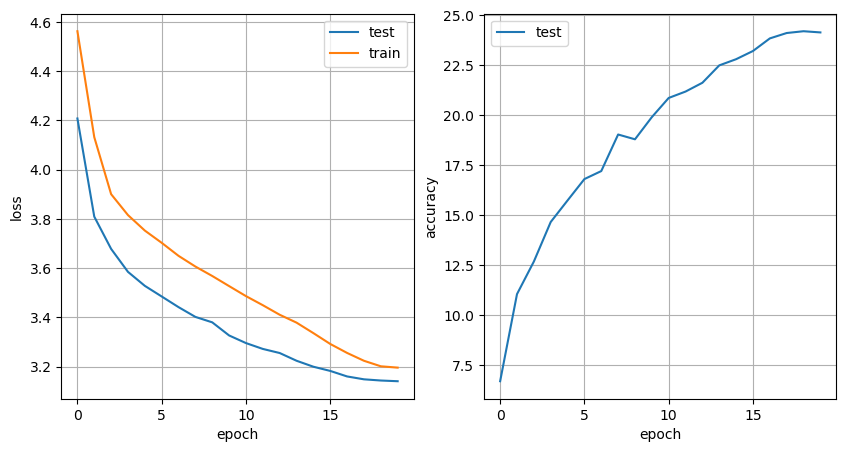

In [57]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(test_loss_history, label='test')
ax1.plot(train_loss_history, label='train')
ax1.legend()
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()

ax2.plot(test_metric_history, label='test')
ax2.legend()
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.grid()

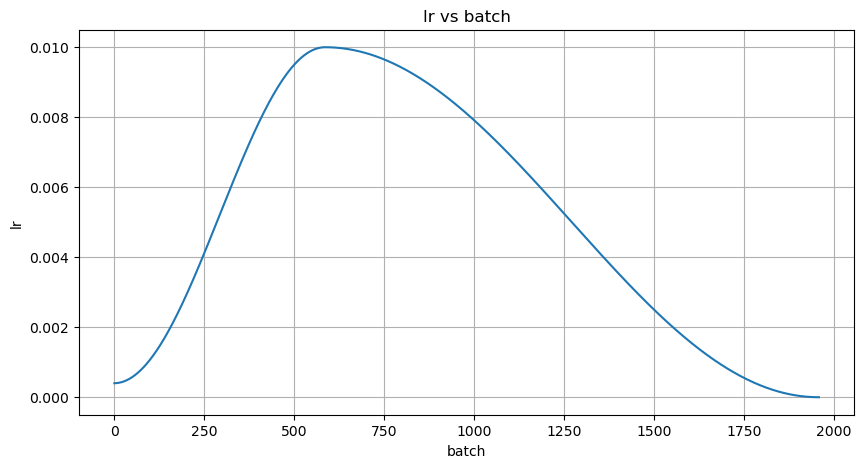

In [59]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(lr_history)
ax.set_xlabel('batch')
ax.set_ylabel('lr')
ax.set_title('lr vs batch')
ax.grid()